## Import Modules

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import numpy as np
import scipy.io as scio
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from mpl_toolkits.axes_grid1 import make_axes_locatable
from algorithm_3ddpc import Solver3DDPC

## Load 3D DPC Measurements

In [2]:
dpc_images = scio.loadmat("../example_3ddpc_dataset.mat")["I_DPC"]  #EXAMPLE 3D POLYSTYRENE BEAD DATASET

## Set System Parameters

In [3]:
wavelength     =  0.514             #in micron
mag            =   41.0             #total magnification of the imaging system
na             =   0.65             #numerical aperture of the imaging system
na_in          =      0             #inner numerical aperture of the source, 0: conventional DPC pattern, >0: annular pattern
pixel_size_cam =    6.5             #pixel size of camera in micron
pixel_size     = pixel_size_cam/mag #in micron
pixel_size_z   =    1.0             #in micron
rotation       = [0, 180, 90, 270]  #degree
RI_medium      =   1.59             #background refractive index

## 3D DPC Reconstruction

### Initialize 3D DPC Solver

In [4]:
solver_3ddpc = Solver3DDPC(dpc_images, wavelength, na, na_in, pixel_size, pixel_size_z, rotation, RI_medium)

### Visualize 3D DPC Intensity
use the slider to view intensity measurements at different $z$ planes

<IPython.core.display.Javascript object>


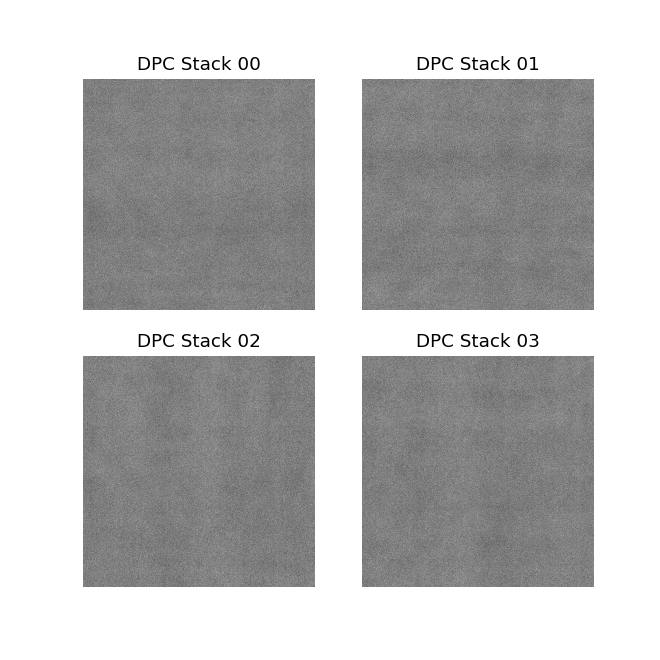

Widget Javascript not detected.  It may not be installed or enabled properly.


<function __main__.updateFrames>

In [5]:
f, ax  = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(6, 6))
frames = []
for plot_index in range(4):
    plot_row = plot_index//2
    plot_col = np.mod(plot_index, 2)
    frames.append(ax[plot_row, plot_col].imshow(solver_3ddpc.dpc_imgs[:, :, 0, plot_index], clim=(-0.2, 0.2), cmap="gray",\
                                  extent=[0, solver_3ddpc.dpc_imgs.shape[0], 0, solver_3ddpc.dpc_imgs.shape[1]]))
    ax[plot_row, plot_col].axis("off")
    ax[plot_row, plot_col].set_title("DPC Stack {:02d}".format(plot_index))
    
def updateFrames(z_index):
    for plot_index in range(4):
        frames[plot_index].set_data(solver_3ddpc.dpc_imgs[:, :, z_index, plot_index])

interact(updateFrames, z_index=IntSlider(min=0,max=solver_3ddpc.dpc_imgs.shape[2]-1,step=1,value=0))

### Visualize DPC Source Patterns

<IPython.core.display.Javascript object>


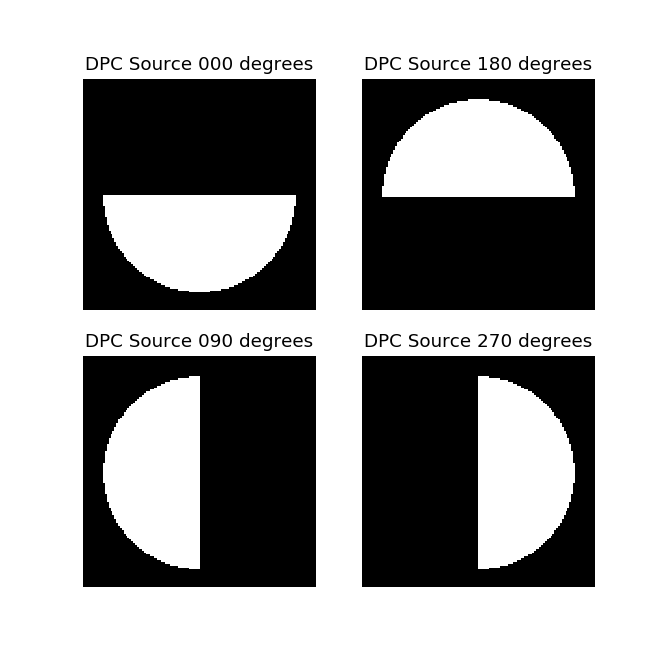

In [6]:
#plot the sources
max_na_x = max(solver_3ddpc.fxlin.real*solver_3ddpc.wavelength/solver_3ddpc.na)
min_na_x = min(solver_3ddpc.fxlin.real*solver_3ddpc.wavelength/solver_3ddpc.na)
max_na_y = max(solver_3ddpc.fylin.real*solver_3ddpc.wavelength/solver_3ddpc.na)
min_na_y = min(solver_3ddpc.fylin.real*solver_3ddpc.wavelength/solver_3ddpc.na)
f, ax  = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(6, 6))
for plot_index, source in enumerate(list(solver_3ddpc.source)):
    plot_row = plot_index//2
    plot_col = np.mod(plot_index, 2)
    ax[plot_row, plot_col].imshow(np.fft.fftshift(solver_3ddpc.source[plot_index]),\
                                  cmap='gray', clim=(0,1), extent=[min_na_x, max_na_x, min_na_y, max_na_y])
    ax[plot_row, plot_col].axis("off")
    ax[plot_row, plot_col].set_title("DPC Source {:03d} degrees".format(rotation[plot_index]))
    ax[plot_row, plot_col].set_xlim(-1.2, 1.2)
    ax[plot_row, plot_col].set_ylim(-1.2, 1.2)
    ax[plot_row, plot_col].set_aspect(1)

## Visualize 3D Weak Object Transfer Functions
use the slider to view absorption and phase transfer functions at different $f_z$ planes

<IPython.core.display.Javascript object>


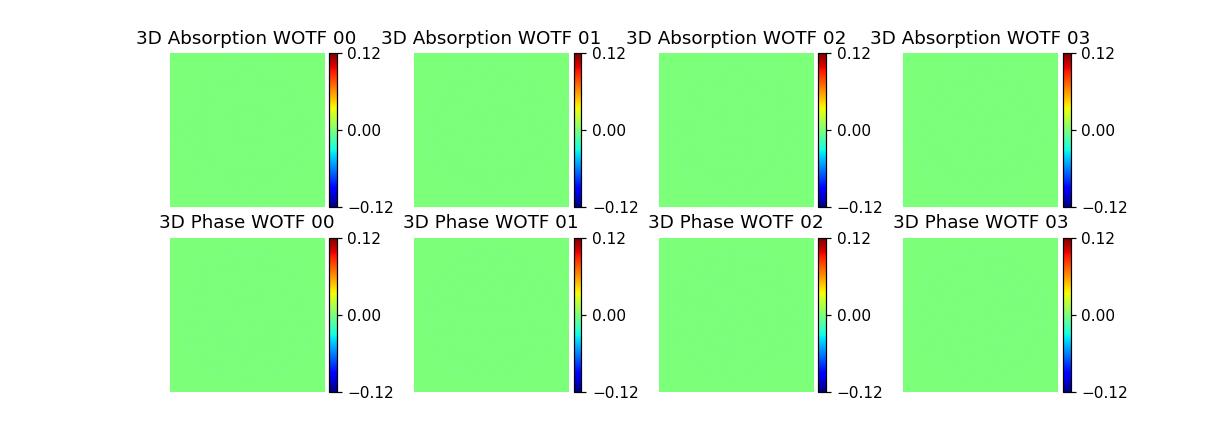

Widget Javascript not detected.  It may not be installed or enabled properly.


<function __main__.updateFrames>

In [7]:
#plot the transfer functions
f, ax         = plt.subplots(2, solver_3ddpc.dpc_num, sharex=True, sharey=True, figsize = (11, 4))
initial_index = np.mod(-dpc_images.shape[2]//2, dpc_images.shape[2])
frames_real   = []
frames_imag   = []

for plot_index in range(ax.size):
    plot_row = plot_index//solver_3ddpc.dpc_num
    plot_col = np.mod(plot_index, solver_3ddpc.dpc_num)
    divider  = make_axes_locatable(ax[plot_row, plot_col])
    cax      = divider.append_axes("right", size="5%", pad=0.05)
    if plot_row == 0:
        frames_imag.append(ax[plot_row, plot_col].imshow(np.fft.fftshift(solver_3ddpc.H_imag[plot_col][:, :, initial_index].real), cmap='jet',\
                                             extent=[min_na_x, max_na_x, min_na_y, max_na_y], clim=(-0.12, 0.12)))
        ax[plot_row, plot_col].set_title("3D Absorption WOTF {:02d}".format(plot_col))
        plt.colorbar(frames_imag[-1], cax=cax, ticks=[-0.12, 0, 0.12])
    else:
        frames_real.append(ax[plot_row, plot_col].imshow(np.fft.fftshift(solver_3ddpc.H_real[plot_col][:, :, initial_index].imag), cmap='jet',\
                                             extent=[min_na_x, max_na_x, min_na_y, max_na_y], clim=(-0.12, 0.12)))
        ax[plot_row, plot_col].set_title("3D Phase WOTF {:02d}".format(plot_col))
        plt.colorbar(frames_real[-1], cax=cax, ticks=[-0.12, 0, 0.12])
    ax[plot_row, plot_col].set_xlim(-2.2, 2.2)
    ax[plot_row, plot_col].set_ylim(-2.2, 2.2)
    ax[plot_row, plot_col].axis("off")
    ax[plot_row, plot_col].set_aspect(1)
    
def updateFrames(fz_index):
    for plot_index in range(solver_3ddpc.dpc_num):
        plot_col = np.mod(plot_index, solver_3ddpc.dpc_num)
        frames_real[plot_index].set_data(np.fft.fftshift(solver_3ddpc.H_real[plot_col][:, :, np.mod(fz_index, dpc_images.shape[2])].imag))
        frames_imag[plot_index].set_data(np.fft.fftshift(solver_3ddpc.H_imag[plot_col][:, :, np.mod(fz_index, dpc_images.shape[2])].real))
        
interact(updateFrames, fz_index=IntSlider(min=-dpc_images.shape[2]//2, max=dpc_images.shape[2]//2, step=1, value=-dpc_images.shape[2]//2))

## Solve 3D DPC Deconvoltion Problems
GPU processing is done using ArrayFire library (https://arrayfire.com/) and its python wrapper (https://github.com/arrayfire/arrayfire-python). Make sure you have a working GPU device with enough memory and install the ArrayFire packages properly before running the GPU codes.

In [8]:
# set use_gpu to be True for GPU computation. Otherwise, the default compuation is done on the CPU.
use_gpu = False

### Tikhonov Regularization
In this section, the algorithm solves the following optimization to find the optimal scattering potential $V$ using Tikhonov regularization, where $\tilde{\cdot}$ is the 3D Fourier transform operator, $I_{DPC}$ is the 3D DPC measurements, $H_{Re}$ and $H_{Im}$ are 3D WOTFs, and $\gamma_{\mathrm{Re}}$ and $\gamma_{\mathrm{Im}}$ are regularization parameters. Finally, the complex scattering potential is converted to the refractive index of the 3D object.

$$V^{\star}=\underset{V}{arg\ min}\sum_{s}\|\tilde{I}_{DPC,s}-H_{\mathrm{Re,s}}\cdot \tilde{V}_{\mathrm{Re}}-H_{\mathrm{Im,s}}\cdot \tilde{V}_{\mathrm{Im}}\|^{2}_{2}+\gamma_{\mathrm{Re}}\|\tilde{V}_{\mathrm{Re}}\|^{2}_{2}+\gamma_{\mathrm{Im}}\|\tilde{V}_{\mathrm{Im}}\|^{2}_{2}$$

In [9]:
solver_3ddpc.setRegularizationParameters(reg_real=5e-5, reg_imag=5e-5)
RI_obj = solver_3ddpc.solve(method="Tikhonov", use_gpu=use_gpu)

========== Solving 3D DPC with Tikhonov regularization ==========


<IPython.core.display.Javascript object>


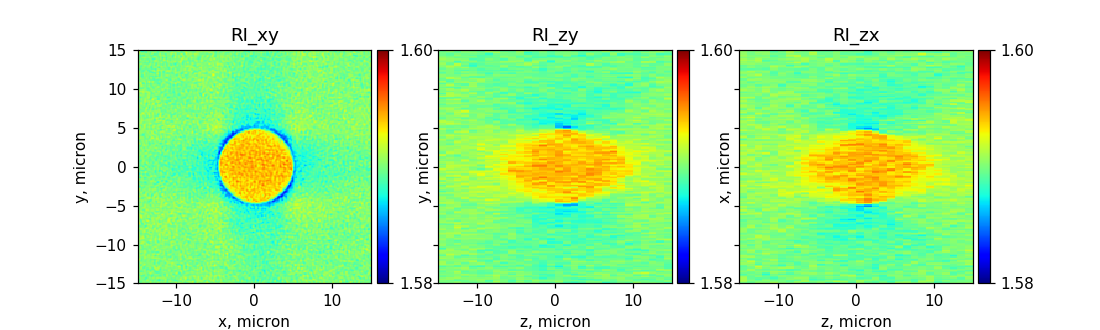

In [10]:
#plot orthogonal slices of the recovered 3D refractive index

_, axes        = plt.subplots(1, 3, figsize=(10, 3), sharex=True, sharey=True)
titles         = ["xy", "zy", "zx"]
xlabels        = ["x", "z", "z"]
ylabels        = ["y", "y", "x"]
display_images = [RI_obj[:, :, RI_obj.shape[2]//2], \
                  RI_obj[:, RI_obj.shape[1]//2, :], \
                  RI_obj[RI_obj.shape[0]//2, :, :]]
extents        = [[-RI_obj.shape[1]//2*pixel_size, RI_obj.shape[1]//2*pixel_size, -RI_obj.shape[0]//2*pixel_size, RI_obj.shape[0]//2*pixel_size], \
                  [-RI_obj.shape[2]//2*pixel_size_z, RI_obj.shape[2]//2*pixel_size_z, -RI_obj.shape[0]//2*pixel_size, RI_obj.shape[0]//2*pixel_size], \
                  [-RI_obj.shape[2]//2*pixel_size_z, RI_obj.shape[2]//2*pixel_size_z, -RI_obj.shape[1]//2*pixel_size, RI_obj.shape[1]//2*pixel_size]]

for plot_index in range(3):
    divider  = make_axes_locatable(axes[plot_index])
    cax      = divider.append_axes("right", size="5%", pad=0.05)
    plot     = axes[plot_index].imshow(display_images[plot_index], extent=extents[plot_index], clim=[RI_medium-1e-2,RI_medium+1e-2], cmap="jet")
    axes[plot_index].axis([-15, 15, -15, 15])
    axes[plot_index].set_xlabel(xlabels[plot_index]+", micron")
    axes[plot_index].set_ylabel(ylabels[plot_index]+", micron")
    plt.colorbar(plot, cax=cax, ticks=[RI_medium-1e-2,RI_medium+1e-2])
    axes[plot_index].set_title("RI_{:s}".format(titles[plot_index]))

### Total Variation Regularization
In this section, an ADMM algorithm solves the following optimization to find the optimal scattering potential $V$ using Tikhonov and total variation (TV) regularizations as well as boundary value constraints, where $\tilde{\cdot}$ is the 3D Fourier transform operator, $I_{DPC}$ is the 3D DPC measurements, $H_{Re}$ and $H_{Im}$ are 3D WOTFs, $\tau$, $\gamma_{\mathrm{Re}}$ and $\gamma_{\mathrm{Im}}$ are regularization parameters, and $\nabla$ is the 3D gradient operator. Finally, the complex scattering potential is converted to the refractive index of the 3D object.

$$V^{\star}=\underset{V_{\mathrm{Re}}, V_{\mathrm{Im}}<0}{arg\ min}\sum_{s}\|\tilde{I}_{DPC,s}-H_{\mathrm{Re,s}}\cdot \tilde{V}_{\mathrm{Re}}-H_{\mathrm{Im,s}}\cdot \tilde{V}_{\mathrm{Im}}\|^{2}_{2}+\gamma_{\mathrm{Re}}\|\tilde{V}_{\mathrm{Re}}\|^{2}_{2}+\gamma_{\mathrm{Im}}\|\tilde{V}_{\mathrm{Im}}\|^{2}_{2}+\tau\|\nabla V\|_{1}$$

In [11]:
solver_3ddpc.setRegularizationParameters(reg_real=5e-5, reg_imag=5e-5, tau = 8e-5, rho=4e-5)
RI_obj = solver_3ddpc.solve(method="TV", tv_max_iter=50, boundary_constraint={"real":"negative", "imag":"negative"}, use_gpu=use_gpu)

========== Solving 3D DPC with total variation regularization and boundary value constraint ==========


<IPython.core.display.Javascript object>


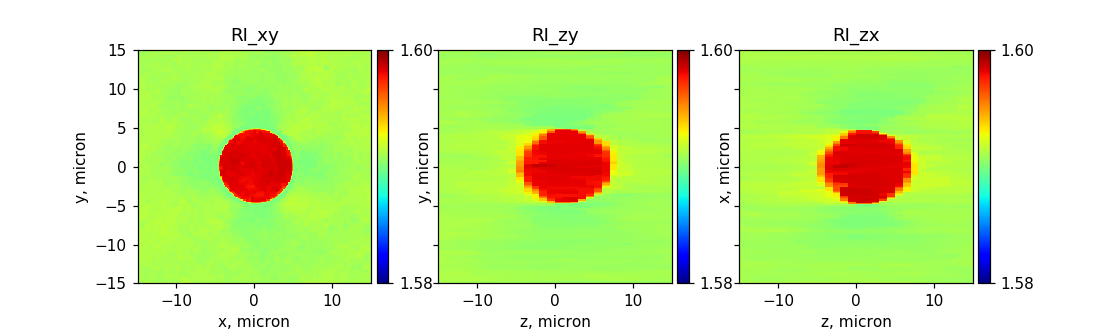

In [12]:
#plot orthogonal slices of the recovered 3D refractive index

_, axes        = plt.subplots(1, 3, figsize=(10, 3), sharex=True, sharey=True)
titles         = ["xy", "zy", "zx"]
xlabels        = ["x", "z", "z"]
ylabels        = ["y", "y", "x"]
display_images = [RI_obj[:, :, RI_obj.shape[2]//2], \
                  RI_obj[:, RI_obj.shape[1]//2, :], \
                  RI_obj[RI_obj.shape[0]//2, :, :]]
extents        = [[-RI_obj.shape[1]//2*pixel_size, RI_obj.shape[1]//2*pixel_size, -RI_obj.shape[0]//2*pixel_size, RI_obj.shape[0]//2*pixel_size], \
                  [-RI_obj.shape[2]//2*pixel_size_z, RI_obj.shape[2]//2*pixel_size_z, -RI_obj.shape[0]//2*pixel_size, RI_obj.shape[0]//2*pixel_size], \
                  [-RI_obj.shape[2]//2*pixel_size_z, RI_obj.shape[2]//2*pixel_size_z, -RI_obj.shape[1]//2*pixel_size, RI_obj.shape[1]//2*pixel_size]]

for plot_index in range(3):
    divider  = make_axes_locatable(axes[plot_index])
    cax      = divider.append_axes("right", size="5%", pad=0.05)
    plot     = axes[plot_index].imshow(display_images[plot_index], extent=extents[plot_index], clim=[RI_medium-1e-2,RI_medium+1e-2], cmap="jet")
    axes[plot_index].axis([-15, 15, -15, 15])
    axes[plot_index].set_xlabel(xlabels[plot_index]+", micron")
    axes[plot_index].set_ylabel(ylabels[plot_index]+", micron")
    plt.colorbar(plot, cax=cax, ticks=[RI_medium-1e-2,RI_medium+1e-2])
    axes[plot_index].set_title("RI_{:s}".format(titles[plot_index]))